In [1]:
%run ../initlibs.py cryptomomentum dark

from models.turtless_model import TurtlesGenerator, RollingHiLo, PivotsBreaks
setup_mpl_theme('dark') # run this if need to switch to light charts theme

# Data loading

In [22]:
# instrument = 'XRPUSDT'
# instrument = 'BTCUSDT'
instrument = 'ETHUSDT'
data_1m = load_binance_data(instrument, '1m', path='../data')

# Rolling High/Low breakouts

We inspect simplest brealkout model - when price breaks up rolling high or breaks down rolling low.

In [3]:
def find_rhl_breakouts(data, timeframe, period):
    htf = ohlc_resample(data, timeframe, resample_tz='UTC')
    top = htf.rolling(period, min_periods=period).high.apply(lambda x: max(x))
    bot = htf.rolling(period, min_periods=period).low.apply(lambda x: min(x))

    hilo = pd.concat((top.rename('Top'), bot.rename('Bot')), axis=1)
    hilo.index = hilo.index + pd.Timedelta(timeframe)
    hilo = data.combine_first(hilo).fillna(method='ffill')[hilo.columns]
    d_1 = data.shift(1)[['open', 'close']].rename(columns={'open': 'open_1', 'close': 'close_1'})
    t = pd.concat((data[['open', 'close']], d_1, hilo), axis=1)

    poi = pd.concat((
        pd.Series(+1, t[(t.open_1 < t.Top) & (t.close_1 < t.Top) & (t.close > t.Top)].index),
        pd.Series(-1, t[(t.open_1 > t.Bot) & (t.close_1 > t.Bot) & (t.close < t.Bot)].index))).sort_index()
    
    return mstruct(poi=poi, hilo=hilo)

First test it on 1H timeframes and use 6 previous hours for detecting rolling highs/lows. 
We'll find points where price breaks these rolling highs or lows (let's call them points of interests POI) and using these POI's data we can calculate simple statistics for forward returns (after breaks happened).

For instance we can find out what's average forward return after breaking high/low for different time horizons (next 1 hour, 2 hours, ... 24 hours

In [23]:
data = ohlc_resample(data_1m, '1H')

# r is forward returns matrix for different time horizons 1h, 2h, ... 24h in quoted currency
r = make_forward_returns_matrix(data, 24, use_open_close=False, use_usd_rets=True)
r.head()

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,...,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24
time,,,,,,,,,,,,,,,,,,,,,
2017-08-17 04:00:00,-0.42,4.86,5.52,6.90,6.20,5.85,5.52,6.30,3.40,3.96,...,1.69,4.34,3.64,-1.10,-1.91,-4.37,-2.58,-1.70,-1.30,1.60
2017-08-17 05:00:00,5.28,5.94,7.32,6.62,6.27,5.94,6.72,3.82,4.38,5.32,...,4.76,4.06,-0.68,-1.49,-3.95,-2.16,-1.28,-0.88,2.02,4.32
2017-08-17 06:00:00,0.66,2.04,1.34,0.99,0.66,1.44,-1.46,-0.90,0.04,0.37,...,-1.22,-5.96,-6.77,-9.23,-7.44,-6.56,-6.16,-3.26,-0.96,-1.72
2017-08-17 07:00:00,1.38,0.68,0.33,0.00,0.78,-2.12,-1.56,-0.62,-0.29,0.48,...,-6.62,-7.43,-9.89,-8.10,-7.22,-6.82,-3.92,-1.62,-2.38,-4.39
2017-08-17 08:00:00,-0.70,-1.05,-1.38,-0.60,-3.50,-2.94,-2.00,-1.67,-0.90,-8.40,...,-8.81,-11.27,-9.48,-8.60,-8.20,-5.30,-3.00,-3.76,-5.77,-5.29


In [24]:
b = find_rhl_breakouts(data, '1h', 6)
print(f'> Found {len(b.poi)} points of interest')

poi = b.poi
s_fun = lambda x: x.mean()
ht_stats = pd.concat(( s_fun(r.loc[poi[poi > 0].index]), s_fun(r.loc[poi[poi < 0].index])), axis=1, keys=['BreakHi','BreakLo'])

> Found 4252 points of interest


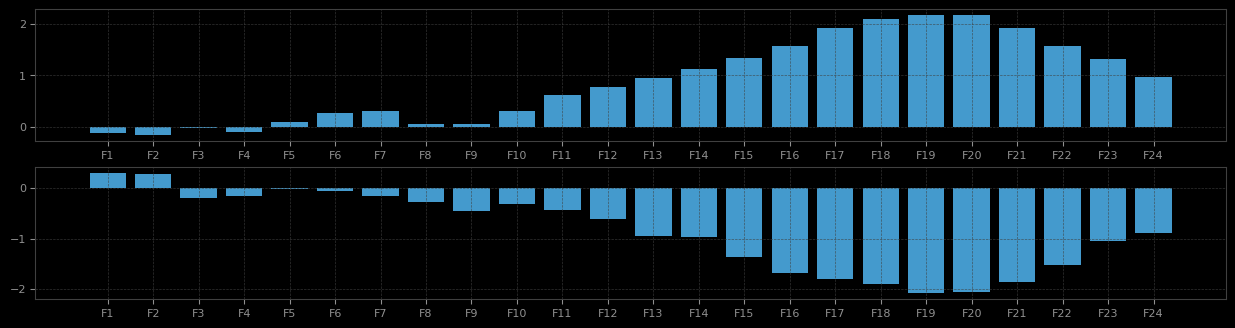

In [25]:
fig(16, 4)
sbp(21,1); plt.bar(ht_stats.index, ht_stats.BreakHi)
sbp(21,2); plt.bar(ht_stats.index, ht_stats.BreakLo);

We can see that breakout demonstrates stronger direction predictivity for longer time horizons.

So if we'd take position (long after break up and short after) and just hold it for 20 hours and then close it we should get maximal profit. 

In [26]:
def rough_simulation(poi, trade_long, trade_short, fwd_returns, holding_time, commissions):
    buys = poi[poi > 0]    # long when breaks rolling high
    sells = poi[poi < 0]   # short when breask rolling low
    holding_time = f'F{holding_time}' if isinstance(holding_time, int) else holding_time
    
    pfl = pd.concat((+trade_long * r.loc[buys.index][holding_time], 
                     -trade_short * r.loc[sells.index][holding_time]), axis=0).sort_index()

    # we use double commissions (open and close position)
    comms = 2*data.loc[pfl.index].close * commissions
    
    # apply commissions correctly
    pp = pfl[pfl > 0]
    pp = pp - comms[pp.index]
    pn = pfl[pfl < 0]
    pn = pn - comms[pn.index]
    return pd.concat((pp , pn)).sort_index()

In [27]:
# commissions 0.1% per btc
commissions = 0.1 / 100

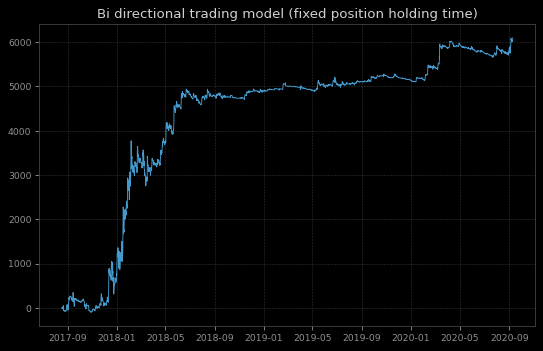

In [28]:
# so if we'd trade bidirectional model using 20 hours limitated holding time
rets = rough_simulation(poi, 1, 1, r, 20, commissions)
plt.plot(rets.cumsum());
plt.title('Bi directional trading model (fixed position holding time)');

Interesting to compare long only and short only models:

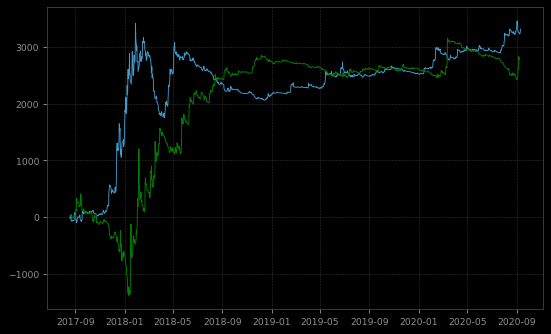

In [29]:
r_long_only = rough_simulation(poi, 1, 0, r, 20, commissions)
r_short_only = rough_simulation(poi, 0, 1, r, 20, commissions)
plt.plot(r_long_only.cumsum())
plt.plot(r_short_only.cumsum());

We can check all positions holding times (from 1h to 24h) and compare equities

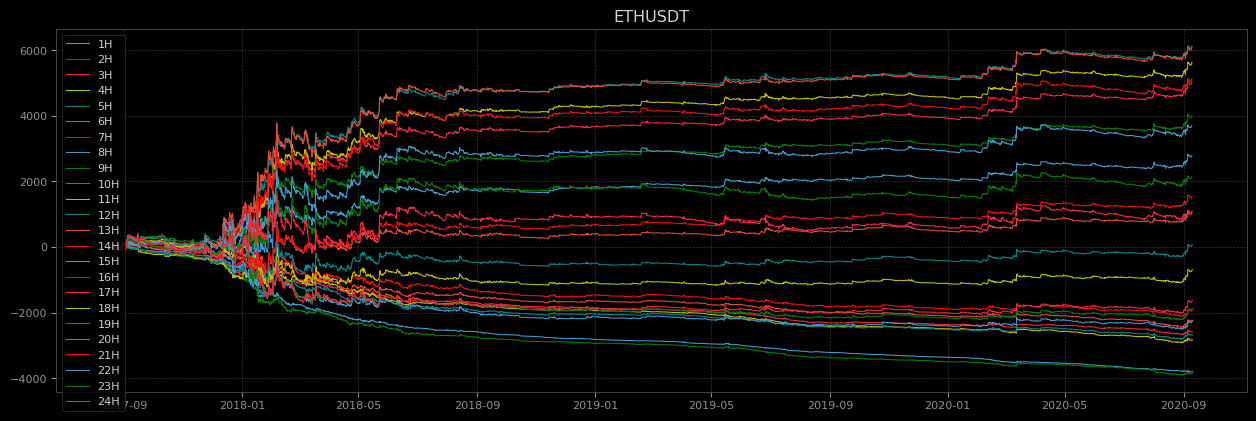

In [30]:
fig(16, 5)
for holding_time in ht_stats.index:
    rets = rough_simulation(poi, 1, 1, r, holding_time, commissions)
    plt.plot(rets.cumsum(), label=holding_time.split('F')[1]+'H')
    
plt.legend(); plt.title(instrument);

# Find best parameters 

Now let's try to find best parameters for timeframe, rolling window size and holding time.

In [31]:
data = ohlc_resample(data_1m, '1H')
r = make_forward_returns_matrix(data, 24, use_open_close=False, use_usd_rets=True)

In [32]:
s_fun = lambda x: x.mean()
sims = {}
for s in tqdm(permutate_params({    
    'timeframe': ['1H', '2H', '3H', '4H', '5H', '6H', '7h', '8h', '1D'], 
    'period': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12]})):
    b = find_rhl_breakouts(data, **s)
    poi = b.poi
    ht_stats = pd.concat(( s_fun(r.loc[poi[poi > 0].index]), s_fun(r.loc[poi[poi < 0].index])), axis=1, keys=['BreakHi','BreakLo'])
    
    best_hold_time_df = ht_stats[np.sign(ht_stats).sum(axis=1)==0].sort_values(['BreakHi','BreakLo'], ascending=[False, True])
    if len(best_hold_time_df) > 0:
        best_hold_time = best_hold_time_df.index[0]
        if best_hold_time:
            rets = rough_simulation(poi, 1, 1, r, best_hold_time, commissions)
            sims[str(s)] = mstruct(equity=rets.cumsum(), terminal_pnl=rets.sum(), num_poi=len(poi), params=s, hold_time=best_hold_time)

Now let's see the results (simplest approach - we seslect set that led to maximal terminal PnL)

Interesting to see that all best performers are in 1H timeframe and worst on daily bars

In [33]:
best = pd.DataFrame.from_dict({k:s.to_dict() for k,s in sims.items()}, orient='index').sort_values('terminal_pnl', ascending=False)
best.head(10)

,equity,terminal_pnl,num_poi,params,hold_time
"{'timeframe': '1H', 'period': 7}",time 2017-08-18 14:00:00 15.62296 2017-08...,6288.51134,3868,"{'timeframe': '1H', 'period': 7}",F20
"{'timeframe': '1H', 'period': 10}",time 2017-08-18 17:00:00 2.79894 2017-08...,6219.88928,3073,"{'timeframe': '1H', 'period': 10}",F19
"{'timeframe': '1H', 'period': 8}",time 2017-08-18 14:00:00 7.90296 2017-08...,6149.65982,3552,"{'timeframe': '1H', 'period': 8}",F18
"{'timeframe': '1H', 'period': 9}",time 2017-08-18 14:00:00 11.06296 2017-08...,6135.58604,3280,"{'timeframe': '1H', 'period': 9}",F19
"{'timeframe': '1H', 'period': 6}",time 2017-08-17 14:00:00 -2.43300 2017-08...,6133.35232,4252,"{'timeframe': '1H', 'period': 6}",F19
"{'timeframe': '1H', 'period': 11}",time 2017-08-18 17:00:00 2.79894 2017-08...,5883.05114,2903,"{'timeframe': '1H', 'period': 11}",F19
"{'timeframe': '1H', 'period': 5}",time 2017-08-17 09:00:00 -2.92000 2017-08...,5605.43430,4736,"{'timeframe': '1H', 'period': 5}",F20
"{'timeframe': '1H', 'period': 12}",time 2017-08-18 17:00:00 2.79894 2017-08...,5318.97550,2746,"{'timeframe': '1H', 'period': 12}",F19
"{'timeframe': '1H', 'period': 4}",time 2017-08-17 09:00:00 -5.22000 2017-08...,4910.31836,5371,"{'timeframe': '1H', 'period': 4}",F19
"{'timeframe': '2H', 'period': 5}",time 2017-08-18 17:00:00 2.79894 2017-08...,4904.17346,2816,"{'timeframe': '2H', 'period': 5}",F19


In [34]:
best.tail(10)

,equity,terminal_pnl,num_poi,params,hold_time
"{'timeframe': '8h', 'period': 7}",time 2017-08-19 11:00:00 -5.69516 2017-08-...,881.59472,864,"{'timeframe': '8h', 'period': 7}",F20
"{'timeframe': '7h', 'period': 8}",time 2017-08-19 11:00:00 -5.69516 2017-08-...,862.72880,853,"{'timeframe': '7h', 'period': 8}",F20
"{'timeframe': '1D', 'period': 8}",time 2017-08-27 23:00:00 -4.27626 2017-08-...,860.55860,364,"{'timeframe': '1D', 'period': 8}",F20
"{'timeframe': '8h', 'period': 10}",time 2017-08-21 05:00:00 -9.42810 2017-08-...,846.79184,715,"{'timeframe': '8h', 'period': 10}",F20
"{'timeframe': '7h', 'period': 11}",time 2017-08-21 05:00:00 -9.42810 2017-08-...,845.14086,723,"{'timeframe': '7h', 'period': 11}",F20
"{'timeframe': '7h', 'period': 12}",time 2017-08-21 05:00:00 -9.42810 2017-08-...,814.48104,679,"{'timeframe': '7h', 'period': 12}",F20
"{'timeframe': '1D', 'period': 9}",time 2017-08-27 23:00:00 -4.27626 2017-08-...,782.98858,346,"{'timeframe': '1D', 'period': 9}",F20
"{'timeframe': '1D', 'period': 11}",time 2017-08-28 02:00:00 4.34832 2017-08-...,680.30642,309,"{'timeframe': '1D', 'period': 11}",F19
"{'timeframe': '1D', 'period': 10}",time 2017-08-27 23:00:00 -3.36626 2017-08-...,312.38398,330,"{'timeframe': '1D', 'period': 10}",F16
"{'timeframe': '1D', 'period': 12}",time 2017-08-29 04:00:00 21.05664 2017-08-...,210.04130,295,"{'timeframe': '1D', 'period': 12}",F16


So first 10 best and worst models:

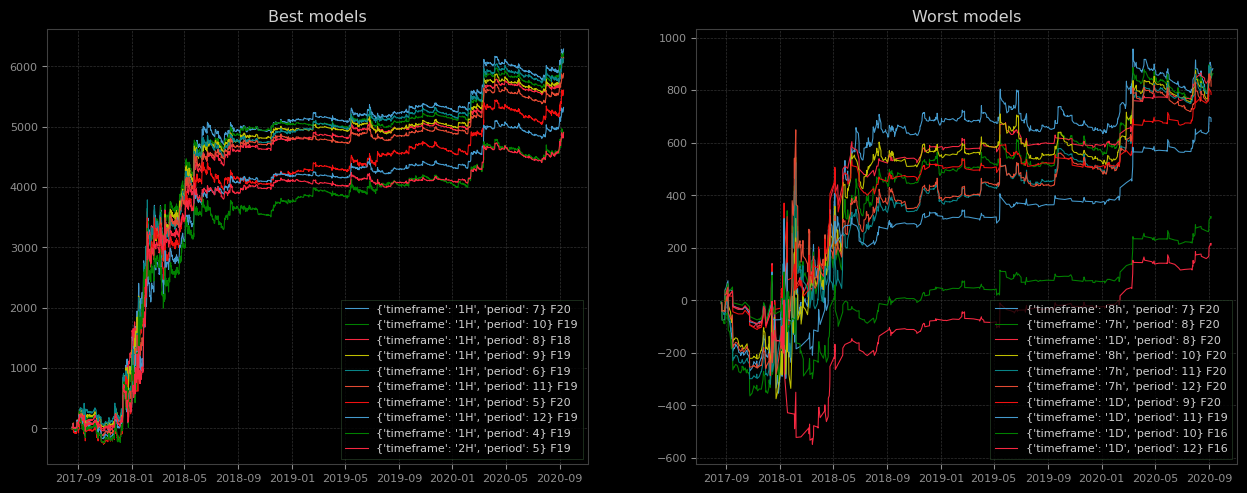

In [35]:
fig(16, 6)
sbp(12,1)
for i in range(10):
    plt.plot(best.equity[i], label=best.index[i] + ' ' + best.hold_time[i])
plt.legend(); plt.title('Best models')
sbp(12,2)
for i in range(-10,0):
    plt.plot(best.equity[i], label=best.index[i] + ' ' + best.hold_time[i])
plt.legend(); plt.title('Worst models');

# Conclusions on rolling High/Low breakout (for BTC)

1. It works better on smaller timeframes and smaller rolling window size (1H, 2H and 5-10 bars lookback).
2. It's better to be used as predictor of forward momentum for 16-17 hours horizon
3. It works better during trend market periods (range Jan'18-May'19 looks mostly flat)
4. Long/Short trading model must be applied to catch both trend sides